# Unsupervised ML Project: Music Clustering
Categorize music by similar audio features




### Problem Statement: 
With the increased diversity in music, classifying music is hard and current genre classification is not a good option as it is bounded by a wide range of subjectivity. Same track may be labelled as a different genre by different people. Music recommendation engines (MRE) could be improved by removing bias and using descriptive music genres like Netflix descriptive movie genres. Categorizing music by similar audio features would better describe music than existing genres. 

### Approach
k-means clustering

### Data
The data used is from the FMA: Free Music Archive (Github https://github.com/mdeff/fma/#fma-a-dataset-for-music-analysis , Kaggle https://www.kaggle.com/datasets/imsparsh/fma-free-music-archive-small-medium).
- tracks.csv: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks
- genres.csv: all 163 genres with name and parent (used to infer the genre hierarchy and top-level genres)
- echonest.csv: audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks

### Audio Features
audio features defined by @Spotify:
- acousticness: [0–1] Confidence measure of whether the track is acoustic.
- danceability: [0–1] Describes how suitable a track is for dancing based on musical attributes including tempo, rhythm, stability, beat strength, and overall regularity.
- energy: [0–1] Perceptual measure of intensity and activity. Energetic tracks feel fast, loud, and noisy (e.g. death metal: high energy, Bach prelude: low energy).
- instrumentalness: [0–1] Predicts whether a track contains no vocals (values above 0.5 represent instrumental tracks whereas rap songs would have a score close to 0).
- liveness: [0–1] Detects the presence of an audience in the recording.
- loudness: [-60–0 dB] The average volume across an entire track.
- speechiness: [0–1] Detects the presence of spoken words in a track (values above 0.66 describe tracks that are probably made entirely of spoken words, 0.33–0.66 describe tracks that may contain both music and speech, and values below 0.33 most likely represent music and other non-speech-like tracks).
- valence: [0–1] Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- tempo: [0–300 BPM] The speed or pace of a given piece, as derived from the estimated average beat duration.

In [1]:
# libraries 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
# datasets
tracks = pd.read_csv('/kaggle/input/fma-free-music-archive-small-medium/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
genres = pd.read_csv('/kaggle/input/fma-free-music-archive-small-medium/fma_metadata/genres.csv')
spotify_data = pd.read_csv('/kaggle/input/fma-free-music-archive-small-medium/fma_metadata/echonest.csv', index_col=0, header=[0, 1])

### Data Understanding

#### tracks.csv

In [3]:
tracks.shape                   # rows & columns

(106574, 52)

In [4]:
tracks.info()                  # dtypes and other info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   (album, comments)            106574 non-null  int64  
 1   (album, date_created)        103045 non-null  object 
 2   (album, date_released)       70294 non-null   object 
 3   (album, engineer)            15295 non-null   object 
 4   (album, favorites)           106574 non-null  int64  
 5   (album, id)                  106574 non-null  int64  
 6   (album, information)         83149 non-null   object 
 7   (album, listens)             106574 non-null  int64  
 8   (album, producer)            18060 non-null   object 
 9   (album, tags)                106574 non-null  object 
 10  (album, title)               105549 non-null  object 
 11  (album, tracks)              106574 non-null  int64  
 12  (album, type)                100066 non-null  object 
 13 

In [5]:
tracks.head()                  # top 5 rows

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                        ...       track                         \
         producer tags  ... information interest language_code   
track_id                ...                                      
2             NaN   []  ...         NaN     4656            en   
3             NaN   []  ...         NaN     1470            en   
5             NaN   []  ...         NaN     1933            en   
10            NaN   []  ...         NaN    54881            en   
20            NaN   []  ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [6]:
tracks.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [7]:
tracks[tracks.duplicated()]                    # duplicate rows

Empty DataFrame
Columns: [(album, comments), (album, date_created), (album, date_released), (album, engineer), (album, favorites), (album, id), (album, information), (album, listens), (album, producer), (album, tags), (album, title), (album, tracks), (album, type), (artist, active_year_begin), (artist, active_year_end), (artist, associated_labels), (artist, bio), (artist, comments), (artist, date_created), (artist, favorites), (artist, id), (artist, latitude), (artist, location), (artist, longitude), (artist, members), (artist, name), (artist, related_projects), (artist, tags), (artist, website), (artist, wikipedia_page), (set, split), (set, subset), (track, bit_rate), (track, comments), (track, composer), (track, date_created), (track, date_recorded), (track, duration), (track, favorites), (track, genre_top), (track, genres), (track, genres_all), (track, information), (track, interest), (track, language_code), (track, license), (track, listens), (track, lyricist), (track, number), (track, publisher), (track, tags), (track, title)]
Index: []

[0 rows x 52 columns]

In [8]:
tracks.isna().sum()                            # missing values

album   comments                  0
        date_created           3529
        date_released         36280
        engineer              91279
        favorites                 0
        id                        0
        information           23425
        listens                   0
        producer              88514
        tags                      0
        title                  1025
        tracks                    0
        type                   6508
artist  active_year_begin     83863
        active_year_end      101199
        associated_labels     92303
        bio                   35418
        comments                  0
        date_created            856
        favorites                 0
        id                        0
        latitude              62030
        location              36364
        longitude             62030
        members               59725
        name                      0
        related_projects      93422
        tags                

In [9]:
sum(tracks[('track', 'genres_all')] == '[]')   # blank values

2231

In [10]:
tracks.describe()                               # statistical info

album                                              \
            comments      favorites             id       listens   
count  106574.000000  106574.000000  106574.000000  1.065740e+05   
mean        0.394946       1.286927   12826.933914  3.212031e+04   
std         2.268915       3.133035    6290.261805  1.478532e+05   
min        -1.000000      -1.000000      -1.000000 -1.000000e+00   
25%         0.000000       0.000000    7793.000000  3.361000e+03   
50%         0.000000       0.000000   13374.000000  8.982000e+03   
75%         0.000000       1.000000   18203.000000  2.363500e+04   
max        53.000000      61.000000   22940.000000  3.564243e+06   

                             artist                                \
              tracks       comments      favorites             id   
count  106574.000000  106574.000000  106574.000000  106574.000000   
mean       19.721452       1.894702      30.041915   12036.770404   
std        39.943673       6.297679     100.511408    6881.420867   
min        -1.000000      -1.000000      -1.000000       1.000000   
25%         7.000000       0.000000       1.000000    6443.000000   
50%        11.000000       0.000000       5.000000   12029.500000   
75%        17.000000       1.000000      16.000000   18011.000000   
max       652.000000      79.000000     963.000000   24357.000000   

                                           track                 \
           latitude     longitude       bit_rate       comments   
count  44544.000000  44544.000000  106574.000000  106574.000000   
mean      39.901626    -38.668642  263274.695048       0.031621   
std       18.240860     65.237220   67623.443584       0.321993   
min      -45.878760   -157.526855      -1.000000       0.000000   
25%       39.271398    -79.997459  192000.000000       0.000000   
50%       41.387917    -73.554431  299914.000000       0.000000   
75%       48.856930      4.351710  320000.000000       0.000000   
max       67.286005    175.277000  448000.000000      37.000000   

                                                                  \
            duration      favorites      interest        listens   
count  106574.000000  106574.000000  1.065740e+05  106574.000000   
mean      277.849100       3.182521  3.541310e+03    2329.353548   
std       305.518553      13.513820  1.901743e+04    8028.070647   
min         0.000000       0.000000  2.000000e+00       0.000000   
25%       149.000000       0.000000  5.990000e+02     292.000000   
50%       216.000000       1.000000  1.314000e+03     764.000000   
75%       305.000000       3.000000  3.059000e+03    2018.000000   
max     18350.000000    1482.000000  3.293557e+06  543252.000000   

                      
              number  
count  106574.000000  
mean        8.260945  
std        15.243271  
min         0.000000  
25%         2.000000  
50%         5.000000  
75%         9.000000  
max       255.000000

#### genres.csv

In [11]:
genres.shape

(163, 5)

In [12]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   genre_id   163 non-null    int64 
 1   #tracks    163 non-null    int64 
 2   parent     163 non-null    int64 
 3   title      163 non-null    object
 4   top_level  163 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 6.5+ KB


In [13]:
genres.head()

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [14]:
genres.columns

Index(['genre_id', '#tracks', 'parent', 'title', 'top_level'], dtype='object')

In [15]:
genres[genres.duplicated()]                         

,genre_id,#tracks,parent,title,top_level


In [16]:
genres.isna().sum()

genre_id     0
#tracks      0
parent       0
title        0
top_level    0
dtype: int64

In [17]:
genres.describe()

,genre_id,#tracks,parent,top_level
count,163.000000,163.000000,163.000000,163.000000
mean,254.116564,2142.085890,60.447853,51.374233
std,265.048642,5199.542574,185.396011,211.470836
min,1.000000,0.000000,0.000000,2.000000
25%,60.500000,125.000000,5.000000,5.000000
50%,172.000000,563.000000,15.000000,12.000000
75%,400.500000,1846.500000,38.000000,20.000000
max,1235.000000,38154.000000,1235.000000,1235.000000


#### echonest.csv

In [18]:
spotify_data.shape

(13131, 249)

In [19]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13131 entries, nan to 124911
Columns: 249 entries, ('echonest', 'audio_features') to ('echonest', 'temporal_features.223')
dtypes: float64(224), object(25)
memory usage: 25.0+ MB


In [20]:
spotify_data.head()

echonest                                                      \
         audio_features audio_features.1 audio_features.2  audio_features.3   
NaN        acousticness     danceability           energy  instrumentalness   
track_id            NaN              NaN              NaN               NaN   
2          0.4166752327     0.6758939853     0.6344762684      0.0106280683   
3          0.3744077685     0.5286430621     0.8174611317      0.0018511032   
5          0.0435668989     0.7455658702     0.7014699916      0.0006967990   

                                                                              \
         audio_features.4 audio_features.5 audio_features.6 audio_features.7   
NaN              liveness      speechiness            tempo          valence   
track_id              NaN              NaN              NaN              NaN   
2            0.1776465712     0.1593100648   165.9220000000     0.5766609880   
3            0.1058799438     0.4618181276   126.9570000000     0.2692402421   
5            0.3731433124     0.1245953419   100.2600000000     0.6216612236   

                                  ...                        \
            metadata  metadata.1  ... temporal_features.214   
NaN       album_date  album_name  ...            214.000000   
track_id         NaN         NaN  ...                   NaN   
2                NaN         NaN  ...             -1.992303   
3                NaN         NaN  ...             -1.582331   
5                NaN         NaN  ...             -2.288358   

                                                                            \
         temporal_features.215 temporal_features.216 temporal_features.217   
NaN                 215.000000            216.000000            217.000000   
track_id                   NaN                   NaN                   NaN   
2                     6.805694              0.233070              0.192880   
3                     8.889308              0.258464              0.220905   
5                    11.527109              0.256821              0.237820   

                                                                            \
         temporal_features.218 temporal_features.219 temporal_features.220   
NaN                 218.000000             219.00000             220.00000   
track_id                   NaN                   NaN                   NaN   
2                     0.027455               0.06408               3.67696   
3                     0.081368               0.06413               6.08277   
5                     0.060122               0.06014               5.92649   

                                                                            
         temporal_features.221 temporal_features.222 temporal_features.223  
NaN                  221.00000            222.000000            223.000000  
track_id                   NaN                   NaN                   NaN  
2                      3.61288             13.316690            262.929749  
3                      6.01864             16.673548            325.581085  
5                      5.86635             16.013849            356.755737  

[5 rows x 249 columns]

In [21]:
spotify_data.columns

MultiIndex([('echonest',        'audio_features'),
            ('echonest',      'audio_features.1'),
            ('echonest',      'audio_features.2'),
            ('echonest',      'audio_features.3'),
            ('echonest',      'audio_features.4'),
            ('echonest',      'audio_features.5'),
            ('echonest',      'audio_features.6'),
            ('echonest',      'audio_features.7'),
            ('echonest',              'metadata'),
            ('echonest',            'metadata.1'),
            ...
            ('echonest', 'temporal_features.214'),
            ('echonest', 'temporal_features.215'),
            ('echonest', 'temporal_features.216'),
            ('echonest', 'temporal_features.217'),
            ('echonest', 'temporal_features.218'),
            ('echonest', 'temporal_features.219'),
            ('echonest', 'temporal_features.220'),
            ('echonest', 'temporal_features.221'),
            ('echonest', 'temporal_features.222'),
            ('e

In [22]:
spotify_data[spotify_data.duplicated()]  

Empty DataFrame
Columns: [(echonest, audio_features), (echonest, audio_features.1), (echonest, audio_features.2), (echonest, audio_features.3), (echonest, audio_features.4), (echonest, audio_features.5), (echonest, audio_features.6), (echonest, audio_features.7), (echonest, metadata), (echonest, metadata.1), (echonest, metadata.2), (echonest, metadata.3), (echonest, metadata.4), (echonest, metadata.5), (echonest, metadata.6), (echonest, ranks), (echonest, ranks.1), (echonest, ranks.2), (echonest, ranks.3), (echonest, ranks.4), (echonest, social_features), (echonest, social_features.1), (echonest, social_features.2), (echonest, social_features.3), (echonest, social_features.4), (echonest, temporal_features), (echonest, temporal_features.1), (echonest, temporal_features.2), (echonest, temporal_features.3), (echonest, temporal_features.4), (echonest, temporal_features.5), (echonest, temporal_features.6), (echonest, temporal_features.7), (echonest, temporal_features.8), (echonest, temporal_features.9), (echonest, temporal_features.10), (echonest, temporal_features.11), (echonest, temporal_features.12), (echonest, temporal_features.13), (echonest, temporal_features.14), (echonest, temporal_features.15), (echonest, temporal_features.16), (echonest, temporal_features.17), (echonest, temporal_features.18), (echonest, temporal_features.19), (echonest, temporal_features.20), (echonest, temporal_features.21), (echonest, temporal_features.22), (echonest, temporal_features.23), (echonest, temporal_features.24), (echonest, temporal_features.25), (echonest, temporal_features.26), (echonest, temporal_features.27), (echonest, temporal_features.28), (echonest, temporal_features.29), (echonest, temporal_features.30), (echonest, temporal_features.31), (echonest, temporal_features.32), (echonest, temporal_features.33), (echonest, temporal_features.34), (echonest, temporal_features.35), (echonest, temporal_features.36), (echonest, temporal_features.37), (echonest, temporal_features.38), (echonest, temporal_features.39), (echonest, temporal_features.40), (echonest, temporal_features.41), (echonest, temporal_features.42), (echonest, temporal_features.43), (echonest, temporal_features.44), (echonest, temporal_features.45), (echonest, temporal_features.46), (echonest, temporal_features.47), (echonest, temporal_features.48), (echonest, temporal_features.49), (echonest, temporal_features.50), (echonest, temporal_features.51), (echonest, temporal_features.52), (echonest, temporal_features.53), (echonest, temporal_features.54), (echonest, temporal_features.55), (echonest, temporal_features.56), (echonest, temporal_features.57), (echonest, temporal_features.58), (echonest, temporal_features.59), (echonest, temporal_features.60), (echonest, temporal_features.61), (echonest, temporal_features.62), (echonest, temporal_features.63), (echonest, temporal_features.64), (echonest, temporal_features.65), (echonest, temporal_features.66), (echonest, temporal_features.67), (echonest, temporal_features.68), (echonest, temporal_features.69), (echonest, temporal_features.70), (echonest, temporal_features.71), (echonest, temporal_features.72), (echonest, temporal_features.73), (echonest, temporal_features.74), ...]
Index: []

[0 rows x 249 columns]

In [23]:
spotify_data.isna().sum()

echonest  audio_features           1
          audio_features.1         1
          audio_features.2         1
          audio_features.3         1
          audio_features.4         1
                                  ..
          temporal_features.219    1
          temporal_features.220    1
          temporal_features.221    1
          temporal_features.222    1
          temporal_features.223    1
Length: 249, dtype: int64

In [24]:
spotify_data.describe()

echonest                                          \
      temporal_features temporal_features.1 temporal_features.2   
count      13130.000000        13130.000000        13130.000000   
mean           0.448322            0.435914            0.365330   
std            0.164849            0.166499            0.133245   
min            0.000000            0.020016            0.015092   
25%            0.332281            0.316450            0.275175   
50%            0.445554            0.432219            0.356016   
75%            0.560122            0.551590            0.442910   
max            0.998426            1.000000            2.000000   

                                                                   \
      temporal_features.3 temporal_features.4 temporal_features.5   
count        13130.000000        13130.000000        13130.000000   
mean             0.306272            0.365795            0.326088   
std              0.121098            0.143048            0.131318   
min              0.014307            0.032791            0.014088   
25%              0.224439            0.268242            0.238669   
50%              0.297742            0.352980            0.318933   
75%              0.376445            0.448602            0.401963   
max              3.000000            4.000000            5.000000   

                                                                   \
      temporal_features.6 temporal_features.7 temporal_features.8   
count        13130.000000        13130.000000        13130.000000   
mean             0.332840            0.358464            0.322465   
std              0.133663            0.143493            0.140416   
min              0.011858            0.011821            0.015987   
25%              0.246158            0.266234            0.235403   
50%              0.325462            0.349883            0.313062   
75%              0.408891            0.436423            0.397813   
max              6.000000            7.000000            8.000000   

                           ...                                              \
      temporal_features.9  ... temporal_features.214 temporal_features.215   
count        13130.000000  ...          13130.000000          13130.000000   
mean             0.358935  ...             -1.949554             10.761507   
std              0.154252  ...              2.543819             20.131455   
min              0.006663  ...            -17.966162             -1.867880   
25%              0.266043  ...             -2.587302              1.229507   
50%              0.348010  ...             -1.565089              4.355798   
75%              0.437750  ...             -0.874871             11.409532   
max              9.000000  ...            214.000000            423.621094   

                                                                         \
      temporal_features.216 temporal_features.217 temporal_features.218   
count          13130.000000          13130.000000          13130.000000   
mean               0.325411              0.271888              0.180467   
std                1.887558              1.893394              3.968928   
min                0.129023              0.098280              0.000518   
25%                0.242371              0.208750              0.021322   
50%                0.286022              0.242757              0.042150   
75%                0.339102              0.285309              0.087523   
max              216.000000            217.000000            375.744781   

                                                                         \
      temporal_features.219 temporal_features.220 temporal_features.221   
count          13130.000000          13130.000000          13130.000000   
mean               0.085200              4.199865              4.131420   
std                1.910658              5.312377              5.315244   
min                0.060000              0.322180      

#### Observations
Tracks File
- rows = 106576 
- columns = 53 
- duplicate rows = 0
- multi-indexing: 3 parent indexes (album, artist, track)
- basic columns for data analysis = album -> id, date_released, title, date_created (for handling missing values in date_released column)
                                 artist -> id, name
                                 track -> genre_top, genres_all, title, duration
- columns with missing values = date_relased, title, genre_top, genres_all
- columns with invalid dtype =  title, date_released, name, genre_top, genres_all

Genres File
- rows = 163 
- columns = 5 
- duplicate rows = 0
- columns with missing values = None
- columns with invalid dtype =  title

Echonest File
- rows = 13132 
- columns = 250 
- duplicate rows = 0
- multi-indexing = 1 parent index (echonest), 6 sub indexes (audio_features, metadata, ranks, social_features, temporal_features)
- basic columns for data analysis: audio_features (acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo, valence)
- columns with missing values = First row index and second row columns
- columns with invalid dtype = acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo, valence

Feature Scaling (Standardization) required

### Data Preprocessing

#### Drop unnecesary columns

In [25]:
# tracks.csv
tracks = tracks[[('album','date_created'), ('album','date_released'), ('album', 'title'), ('album', 'id'),
                 ('artist', 'id'), ('artist', 'name'),  
                 ('track', 'genre_top'), ('track', 'genres_all'),('track', 'title'), ('track', 'duration')]]

In [26]:
# echonest.csv
spotify_data = spotify_data[[('echonest','audio_features'), ('echonest','audio_features.1'), ('echonest','audio_features.2'), ('echonest','audio_features.3'), ('echonest','audio_features.4'), ('echonest','audio_features.5'), ('echonest','audio_features.6'), ('echonest','audio_features.7')]]
spotify_data.columns

MultiIndex([('echonest',   'audio_features'),
            ('echonest', 'audio_features.1'),
            ('echonest', 'audio_features.2'),
            ('echonest', 'audio_features.3'),
            ('echonest', 'audio_features.4'),
            ('echonest', 'audio_features.5'),
            ('echonest', 'audio_features.6'),
            ('echonest', 'audio_features.7')],
           )

#### Remove multi-indexing & rename columns

In [27]:
# tracks.csv
tracks.columns = tracks.columns.droplevel()
tracks.columns = ['date_created', 'date_released', 'album', 'album_id', 'artist_id', 'artist', 'genres_top', 'genres_all', 'track', 'duration']
tracks.columns

Index(['date_created', 'date_released', 'album', 'album_id', 'artist_id',
       'artist', 'genres_top', 'genres_all', 'track', 'duration'],
      dtype='object')

In [28]:
# echonest.csv
spotify_data.columns = spotify_data.columns.droplevel() 
spotify_data.rename(columns=spotify_data.iloc[0], inplace=True)
spotify_data.drop(spotify_data.index[0], inplace=True)
spotify_data.drop(spotify_data.index[0], inplace=True)
# spotify_data = spotify_data.rename(index={np.nan: 'track_id'})
spotify_data.index.name = 'track_id'
spotify_data.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880
3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421
5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236
10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919
134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715


#### Handle missing values

In [29]:
# tracks.csv

# date_released
tracks['date_released'].fillna(tracks['date_created'], inplace=True)      # fill missing date_released value with corresponding value from date_created
tracks['date_released'].fillna(0, inplace=True)                           # fill remaining missing with 0
tracks.drop('date_created', axis=1, inplace=True)                         # remove date_created as date_released missing values has been handled

# genres_all
#tracks.dropna(subset=['genres_all'])
tracks = tracks[tracks['genres_all'] != '[]']              # remove rows that contain [] as genres_all i.e. blank genres_all

# genres_top
tracks['genres_all'] = [map(int, i.strip('][').split(',')) for i in tracks['genres_all']]       # convert string representation of list into list (convert ids represented as string in genres_all to list of ids)
genres_null = tracks.loc[(tracks['genres_top'].isnull()), ['genres_top', 'genres_all']].copy(deep=True)     # rows where genres_all is null, deep copy is made to avoid modifying original dataframe (tracks)
genres_top = genres[genres.top_level == genres.genre_id]                            # genres with no parent, i.e. at the top of the genre hierarchy
genre_top_dict = dict(zip(genres_top.genre_id, genres_top.title))                   # dictionary of genres (key = genre_id : values = genre title)    
for index, row in genres_null.iterrows():                                           # fill null values in genres_top with top genre in genres_all
    for genre in row['genres_all']:
        if genre in genre_top_dict:
            tracks.loc[index, 'genres_top'] = genre_top_dict[genre]
            break
            
# convert genres_all ids to titles
genres_all_dict = dict(zip(genres.genre_id, genres.title))
tracks['genres_all'] = [[genres_all_dict[j] for j in i] for i in tracks['genres_all']]


# title (album, track)
tracks['album'].fillna(tracks['artist'] + '-' + [','.join(i) for i in tracks['genres_all']], inplace=True)     # fill missing album title with corresponding value from artist & genres_all
tracks['track'].fillna(tracks['artist'] + '-' + tracks['genres_top'], inplace=True)                            # fill missing track title with corresponding value from artist & genres_top

tracks.isna().sum()

date_released    0
album            0
album_id         0
artist_id        0
artist           0
genres_top       0
genres_all       0
track            0
duration         0
dtype: int64

#### Format dtype

In [30]:
# tracks.csv
tracks['date_released'] = pd.to_datetime(tracks['date_released'], format='%Y-%m-%d %H:%M:%S')
tracks[['album', 'artist', 'track', 'genres_top']] = tracks[['album', 'artist', 'track', 'genres_top']].astype('string')
tracks.dtypes

date_released    datetime64[ns]
album                    string
album_id                  int64
artist_id                 int64
artist                   string
genres_top               string
genres_all               object
track                    string
duration                  int64
dtype: object

In [31]:
# genres.csv
genres['title'] = genres['title'].astype('string')
genres.dtypes

genre_id      int64
#tracks       int64
parent        int64
title        string
top_level     int64
dtype: object

In [32]:
# echonest.csv
spotify_data = spotify_data.apply(pd.to_numeric)
spotify_data.dtypes

acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
speechiness         float64
tempo               float64
valence             float64
dtype: object

#### Merge tracks metadata & audio features

In [33]:
# dataframe with tracks metadata and audio features

tracks = tracks.loc[tracks.index.isin(spotify_data.index.values)]       # remove rows for which we don't have features i.e track_ids not present in echonest.csv
spotify_tracks = spotify_data.join(tracks, how='inner')                 # merge tracks and spotify_tracks
# spotify_tracks.index = pd.to_numeric(tracks_with_features.index, errors='coerce')
# tracks_with_features.sort_index()
spotify_tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,date_released,album,album_id,artist_id,artist,genres_top,genres_all,track,duration
track_id,,,,,,,,,,,,,,,,,
16117,0.947477,0.448822,0.120015,0.023712,0.149330,0.583456,78.235,0.626038,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Bollate centro,229
16118,0.894214,0.936791,0.154907,0.304732,0.110080,0.545060,119.994,0.718722,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Mi fa,238
16119,0.990624,0.304892,0.101370,0.708325,0.115681,0.053470,89.416,0.493508,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Coma,212
16120,0.396601,0.502328,0.165570,0.002647,0.114401,0.873165,148.676,0.719476,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Capsula spaziale,197
16121,0.903007,0.485873,0.074910,0.717737,0.080096,0.245856,146.322,0.581774,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Confuso,194


#### Feature Scaling

In [34]:
# standardization
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
scaler = StandardScaler()
spotify_tracks[audio_features] = scaler.fit_transform(spotify_tracks[audio_features])
spotify_tracks[audio_features]

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
16117,1.214382,-0.288738,-1.560300,-1.630484,-0.244916,3.742548,-1.289333,0.658010
16118,1.076011,2.287835,-1.433823,-0.869103,-0.497787,3.447874,-0.081401,0.994746
16119,1.326473,-1.048721,-1.627886,0.224370,-0.461701,-0.324836,-0.965908,0.176510
16120,-0.216722,-0.006218,-1.395172,-1.687557,-0.469947,5.965922,0.748261,0.997488
16121,1.098856,-0.093101,-1.723800,0.249871,-0.690958,1.151634,0.680169,0.497194
...,...,...,...,...,...,...,...,...
124857,-1.227317,1.514670,0.611960,0.616653,3.436242,-0.101664,0.535827,1.618701
124862,-1.139235,1.793007,-0.050630,0.649266,2.323196,-0.167273,-0.602623,0.115971
124863,-1.246718,0.560656,1.249374,0.599069,2.870511,-0.339822,0.207919,0.187987


### Data Visualization

array([[<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>]],
      dtype=object)

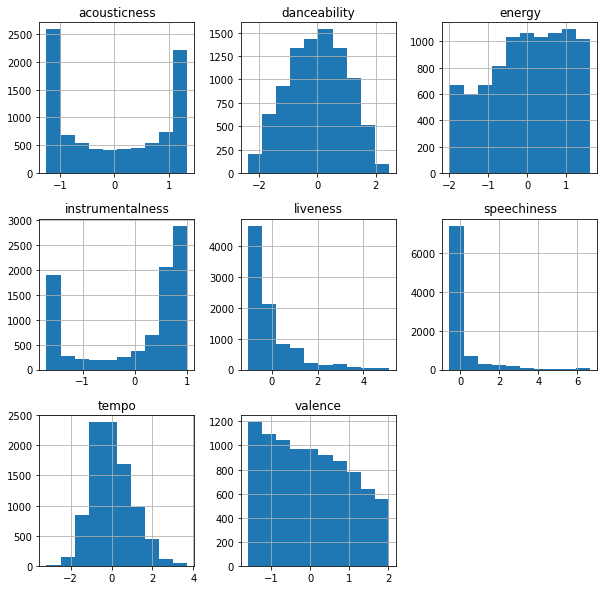

In [35]:
# data distribution
spotify_tracks[audio_features].hist(figsize=(10,10))

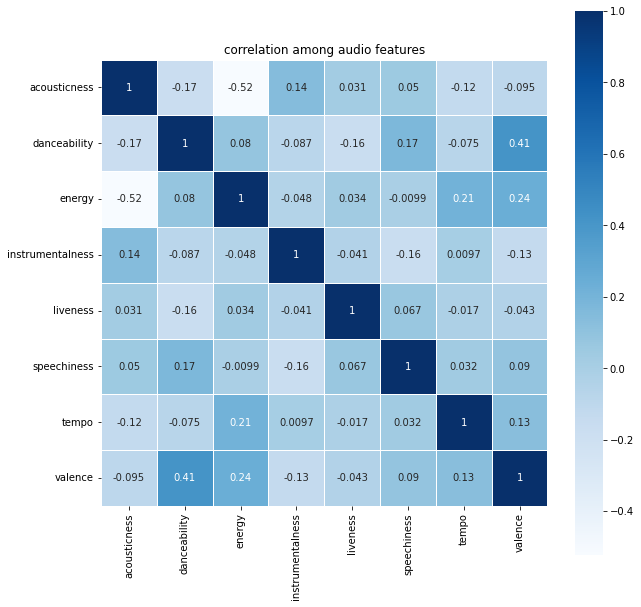

In [36]:
# correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(spotify_tracks[audio_features].corr(), square=True, annot=True, linewidths=.5, cmap="Blues")
plt.title("correlation among audio features")
plt.show()

### Model Development

In [37]:
# K-Means
x = spotify_tracks[audio_features]
kmeans = KMeans(n_clusters=5, random_state=42)
y_predicted = kmeans.fit_predict(x)
y_predicted
# labels = kmeans.labels_


array([1, 1, 3, ..., 2, 4, 3], dtype=int32)

In [38]:
# cluster centers
kmeans.cluster_centers_

array([[-0.755472  , -0.53625806,  0.70314201, -0.13122936, -0.12041015,
        -0.21004897,  0.42665213, -0.34205525],
       [ 0.2683132 ,  0.54526544, -0.17552936, -0.6704076 ,  0.06746033,
         3.25963869,  0.01921581,  0.34438416],
       [ 0.16287023, -0.44794533, -0.01403263,  0.02511889,  2.88424503,
        -0.0728164 , -0.07596762, -0.20603371],
       [ 0.9274552 , -0.46049261, -0.95870326,  0.28215176, -0.25407271,
        -0.31849852, -0.35328829, -0.62475886],
       [-0.27908868,  0.88154143,  0.302966  , -0.01930946, -0.30261241,
        -0.14295452, -0.0354404 ,  0.84920403]])

In [39]:
# add cluster column in spotify_tracks
spotify_tracks['cluster'] = y_predicted
spotify_tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,date_released,album,album_id,artist_id,artist,genres_top,genres_all,track,duration,cluster
track_id,,,,,,,,,,,,,,,,,,
16117,1.214382,-0.288738,-1.560300,-1.630484,-0.244916,3.742548,-1.289333,0.658010,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Bollate centro,229,1
16118,1.076011,2.287835,-1.433823,-0.869103,-0.497787,3.447874,-0.081401,0.994746,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Mi fa,238,1
16119,1.326473,-1.048721,-1.627886,0.224370,-0.461701,-0.324836,-0.965908,0.176510,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Coma,212,3
16120,-0.216722,-0.006218,-1.395172,-1.687557,-0.469947,5.965922,0.748261,0.997488,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Capsula spaziale,197,1
16121,1.098856,-0.093101,-1.723800,0.249871,-0.690958,1.151634,0.680169,0.497194,2006-02-03,Bollate centro,3694,4433,Bacco Baccanels,International,"[Europe, Jazz, Jazz: Vocal, Pop]",Confuso,194,3


### Model Evaluation

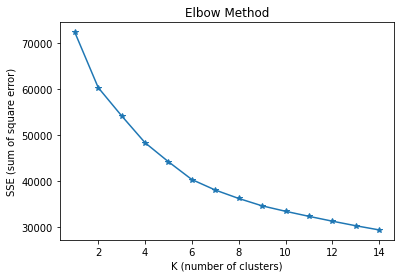

In [40]:
# elbow method
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)
plt.xlabel("K (number of clusters)")
plt.ylabel("SSE (sum of square error)")
plt.title('Elbow Method')
plt.plot(range(1, 15), sse, marker="*")

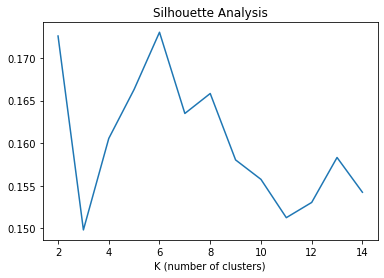

In [41]:
# silhouette analysis
s_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    s_scores.append(silhouette_score(x, kmeans.labels_))
plt.xlabel("K (number of clusters)")
plt.title('Silhouette Analysis')
plt.plot(range(2, 15), s_scores)

Text(0.5, 1.0, 'Clustering by KMeans (k=5)')

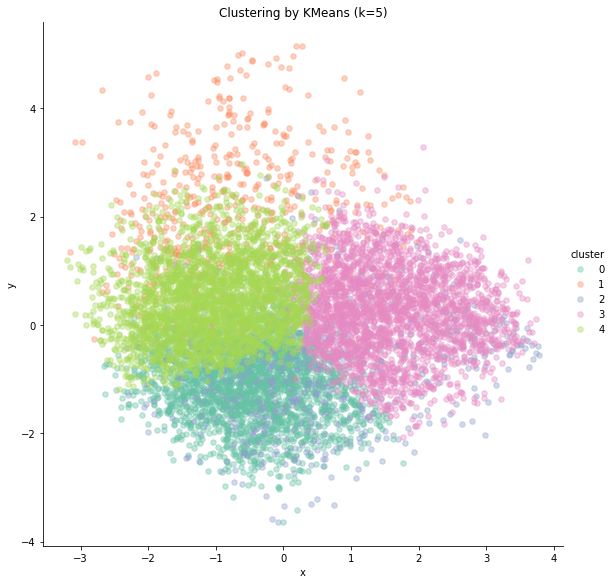

In [42]:
# evaluate visually
pca = PCA(n_components=2)            # reduce dimensions
x = pca.fit_transform(x)
comp_x, comp_y = zip(*x)
# pca.components_
# pca.explained_variance_
# pca.explained_variance_ratio_
# pca.singular_values_
spotify_tracks['x'] = comp_x
spotify_tracks['y'] = comp_y
sns.lmplot(data=spotify_tracks, x='x', y='y', hue='cluster', fit_reg=False, height=8, palette='Set2', scatter_kws={'alpha':0.4, 's':30})
plt.title("Clustering by KMeans (k=5)")

There is no clear boundary between cluster 0 and cluster 2, change k to 4 and evaluate 

In [43]:
# K-Means
x = spotify_tracks[audio_features]
kmeans = KMeans(n_clusters=4, random_state=0)
y_predicted = kmeans.fit_predict(x)
spotify_tracks['cluster'] = y_predicted

Text(0.5, 1.0, 'Clustering by KMeans (k=4)')

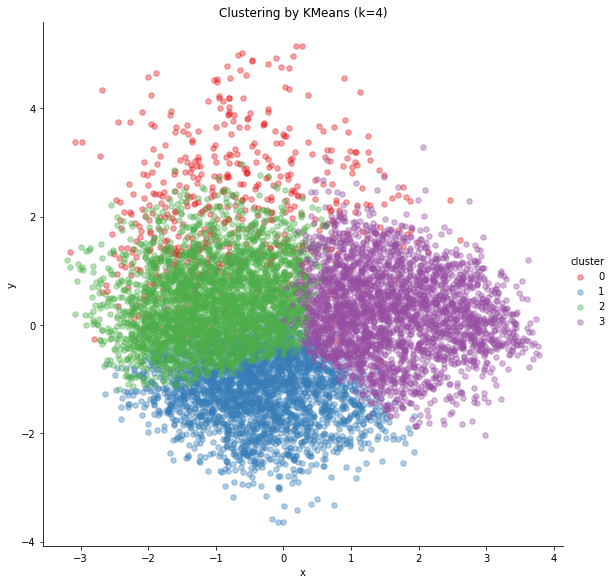

In [44]:
# evaluate visually
pca = PCA(n_components=2)            
x = pca.fit_transform(x)
comp_x, comp_y = zip(*x)
spotify_tracks['x'] = comp_x
spotify_tracks['y'] = comp_y
sns.lmplot(data=spotify_tracks, x='x', y='y', hue='cluster', fit_reg=False, height=8, palette='Set1', scatter_kws={'alpha':0.4, 's':30})
plt.title("Clustering by KMeans (k=4)")

### References
- Victor Ramirez, "Discovering Descriptive Music Genres Using K-Means Clustering," 2018. 
[Online]. Available: https://medium.com/latinxinai/discovering-descriptive-music-genres-using-k-means-clustering-d19bdea5e443

- Sejal Dua, "K-Means Clustering and PCA to categorize music by similar audio features," 2020. [Online]. Available: https://towardsdatascience.com/k-means-clustering-and-pca-to-categorize-music-by-similar-audio-features-df09c93e8b64